# Handwritten Digit Classfication using Convolutional Neural Network

The tutorial presented will again tackle the MNIST digit classification problem. You can find more information from the previous [MNIST introduction](introduction_to_mnist.ipynb) tutorial. This time, we will build a Convolutional Neural Network which is vastly used in many different applications. CNN are networks with loops in them, allowing information to persist. Take a look at [this great blog](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) to gain insights of CNN.

In [1]:
import matplotlib
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
from zoo.common.nncontext import *
redire_spark_logs()
show_bigdl_info_logs()


sc = init_nncontext(init_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)
    
    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda record:
                    Sample.from_ndarray((record[0] - training_mean)/training_std, record[1] + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda record:
                    Sample.from_ndarray((record[0] - training_mean)/training_std, record[1] + 1))
    return (rdd_train_sample, rdd_test_sample)

## 1. Train the network

First, we should get and store MNIST into RDD of Sample.

Note: *edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*.

In [3]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "/tmp/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print(train_data.count())
print(test_data.count())

('Extracting', '/tmp/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Model creation

Let's create the LeNet-5 model.

In [4]:
from bigdl.nn.keras.topology import Sequential
from bigdl.nn.keras.layer import *
from bigdl.dataset import mnist


def build_model(class_num):
    model = Sequential()
    model.add(Reshape((1, 28, 28), input_shape=(28, 28, 1)))
    model.add(Convolution2D(6, 5, 5, activation="tanh", name="conv1_5x5"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(12, 5, 5, activation="tanh", name="conv2_5x5"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation="tanh", name="fc1"))
    model.add(Dense(class_num, activation="softmax", name="fc2"))
    return model

lenet_model = build_model(10)

creating: createKerasSequential
creating: createKerasReshape
creating: createKerasConvolution2D
creating: createKerasMaxPooling2D
creating: createKerasConvolution2D
creating: createKerasMaxPooling2D
creating: createKerasFlatten
creating: createKerasDense
creating: createKerasDense


## 3. Optimizer setup and training

In [5]:
# Create an Optimizer

optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(logProbAsInput=False),
    optim_method=SGD(learningrate=0.4, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(20), 
    batch_size=2048)

# Set the validation logic
optimizer.set_validation(
    batch_size=2048,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'lenet-20181107-010021')


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [6]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 1.57 ms, sys: 8.88 ms, total: 10.5 ms
Wall time: 1min 9s


## 4. Predication on test data

In [7]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

Let's first take a few traing samples and check the labels

Ground Truth labels:
', '.join([str(map_groundtruth_label(s.label.to_ndarray())) for s in train_data.take(8)])


(-0.5, 223.5, 27.5, -0.5)

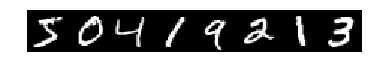

In [8]:
# label-1 to restore the original label.
print("Ground Truth labels:")
print ("', '.join([str(map_groundtruth_label(s.label.to_ndarray())) for s in train_data.take(8)])")
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in train_data.take(8)]),cmap='gray'); plt.axis('off')

Now, let's see the prediction results on test data by our trained model.

Ground Truth labels:
', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
Predicted labels:
', '.join(str(map_predict_label(s)) for s in predictions.take(8))
CPU times: user 114 ms, sys: 229 ms, total: 344 ms
Wall time: 173 ms


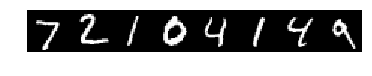

In [9]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print("', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))")
print('Predicted labels:')
print("', '.join(str(map_predict_label(s)) for s in predictions.take(8))")

## 5. Model inspection

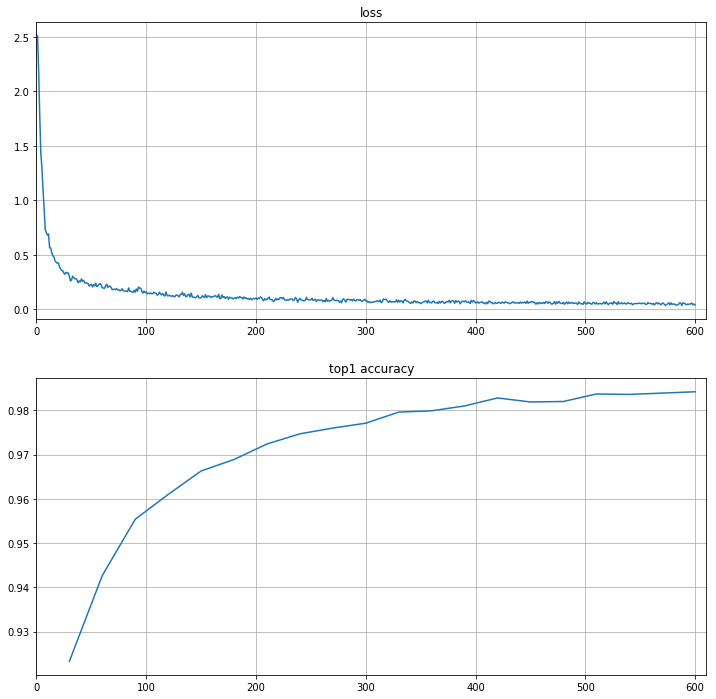

In [10]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)